# ML Models on Simulation Data

In [2]:
# use pip to install pandas, matplotlib if needed
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import set_config
from sklearn.model_selection import train_test_split
set_config(display="text")  # displays text representation of estimators

# survival analysis
from sklearn.model_selection import GridSearchCV, KFold
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.linear_model import CoxPHSurvivalAnalysis, CoxnetSurvivalAnalysis


os.chdir("../")
from scr.utils import *
from scr.runSurvModels import *

# Linear

## Moderate Signal

Train event rate: 0.74375
Test event rate:  0.7515


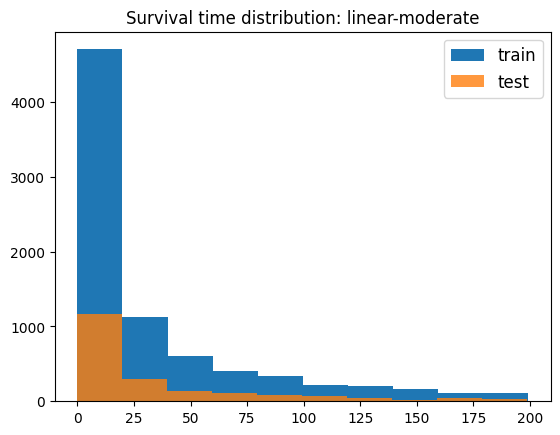

In [3]:
# prepare data
folder = 'linear'
keywords=['moderate', 'latest','RW']
DATANAME = 'linear-moderate'
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords)

X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

plt.hist(train_df['time'], label='train')
plt.hist(test_df['time'], label='test', alpha=0.8)
plt.title('Survival time distribution: %s' % DATANAME)
plt.legend(fontsize=12)
plt.show()
# plt.savefig(f"event_rate_{keyword}.png")

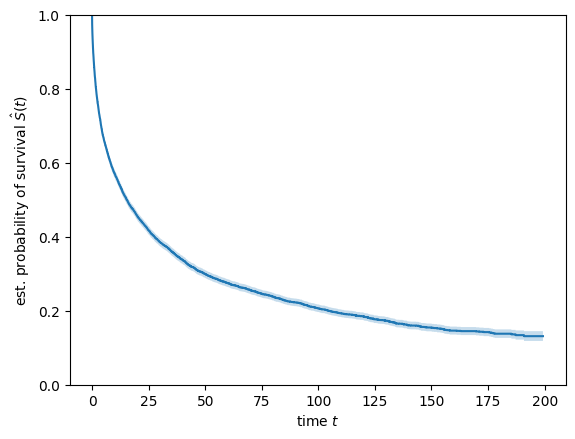

In [4]:
time, survival_prob, conf_int = kaplan_meier_estimator(
    train_df["status"]==1, train_df["time"], conf_type="log-log"
)
plt.step(time, survival_prob, where="post")
plt.fill_between(time, conf_int[0], conf_int[1], alpha=0.25, step="post")
plt.ylim(0, 1)
plt.ylabel(r"est. probability of survival $\hat{S}(t)$")
plt.xlabel("time $t$")
plt.show()

### Hyperparameter Search

/tmp/ipykernel_326640/3953593320.py:1: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=1000).
  coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=1000).fit(X_train, y_train)


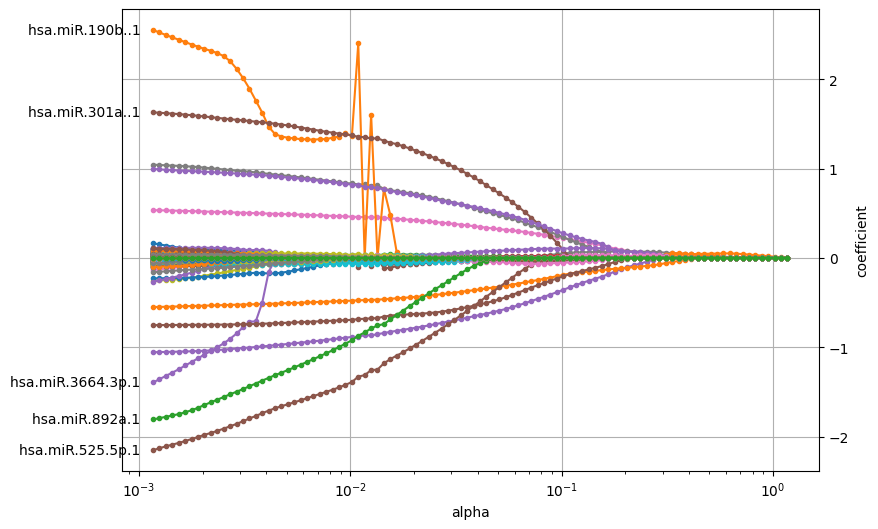

In [37]:
coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alpha_min_ratio=0.001, max_iter=1000).fit(X_train, y_train)
coefficients = pd.DataFrame(coxnet.coef_, index=train_df.columns[:-3], columns=np.round(coxnet.alphas_, 5))
plot_coefficients(coefficients, n_highlight=5)

In [20]:
10 ** np.linspace(-3, 3, 7)

array([1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03])

In [ ]:
# alphas =  10 ** np.linspace(-3, 3, 7) #coxnet.alphas_

# cph_hyperparameters={
#     "alpha": [a for a in alphas],
# }

# cph = CoxPHModel(X_train, y_train, X_test, y_test,
#                             hyperparameters=cph_hyperparameters)
# cph.build_model()
# cph_cv = cph.tune_hyperparameters(n_split=5, plotting_param = "alpha")
# pd.DataFrame(cph_cv)

In [1]:
alphas =  [0.1, 10] #coxnet.alphas_

coxnet_hyperparameters={
    "alphas": [[a] for a in alphas],
    'l1_ratio': [0.1, 0.9]
}
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test,
                            hyperparameters=coxnet_hyperparameters)
coxnet.build_model()
cv_results = coxnet.tune_hyperparameters(n_split=5, plotting_param='alphas')
# cv_results = pd.DataFrame(coxnet.cv_results_)
cv_results

NameError: name 'CoxPHElasticNetModel' is not defined

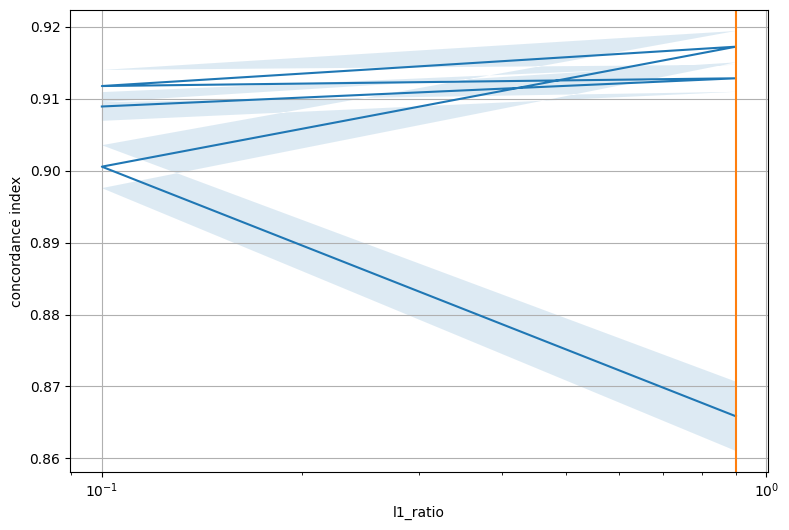

In [37]:
param = 'l1_ratio'
try:
    params = cv_results[f'param_{param}'].map(lambda x: x[0])
except TypeError:
    params = cv_results[f'param_{param}']
mean = cv_results.mean_test_score
std = cv_results.std_test_score


fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(params, mean)
ax.fill_between(params, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_xlabel(param)
ax.set_ylabel("concordance index")
ax.axvline(coxnet_cv.best_params_[param][0] 
            if isinstance(coxnet_cv.best_params_[param], list)
            else coxnet_cv.best_params_[param], 
        c="C1")
ax.grid(True)

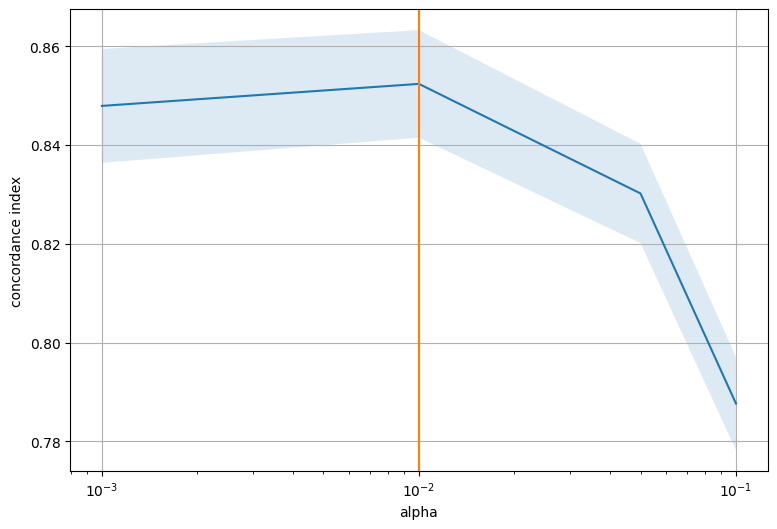

In [50]:
alphas = cv_results.param_alphas.map(lambda x: x[0])
mean = cv_results.mean_test_score
std = cv_results.std_test_score

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(alphas, mean)
ax.fill_between(alphas, mean - std, mean + std, alpha=0.15)
ax.set_xscale("log")
ax.set_ylabel("concordance index")
ax.set_xlabel("alpha")
ax.axvline(coxnet_cv.best_params_["alphas"][0], c="C1")
# ax.axhline(0.5, color="grey", linestyle="--")
ax.grid(True)

In [36]:
coxnet_cv.best_estimator_

CoxnetSurvivalAnalysis(alphas=[0.01], l1_ratio=0.9)

### Training model with best parameter

In [5]:
# parameters for fitting GB models
subset=[
        50,200,500,1000,2000,5000,8000
]
kwargs = {'l1_ratio':0.9, 
        'alphas':[1e-2],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet_results
# coxnet.write(coxnet_dict)

N=50 Training time (0.59s): Train C-Index: 1.0 | Test C-index: 0.648
N=200 Training time (0.22s): Train C-Index: 0.934 | Test C-index: 0.776
N=500 Training time (0.16s): Train C-Index: 0.887 | Test C-index: 0.811


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=1000 Training time (4.14s): Train C-Index: 0.857 | Test C-index: 0.828


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=2000 Training time (8.28s): Train C-Index: 0.844 | Test C-index: 0.835
N=5000 Training time (17.27s): Train C-Index: 0.844 | Test C-index: 0.841


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=8000 Training time (52.36s): Train C-Index: 0.842 | Test C-index: 0.842


,n train,train time,train score,test score
0,50,0.59,1.000000,0.648093
1,200,0.22,0.933649,0.775566
2,500,0.16,0.887245,0.811192
3,1000,4.14,0.856872,0.827545
4,2000,8.28,0.844034,0.835055
5,5000,17.27,0.844302,0.841355
6,8000,52.36,0.841880,0.841885


In [7]:
coxnet_results.to_csv(os.path.join('models', DATANAME, 'coxnet','model.results.1030.txt'))

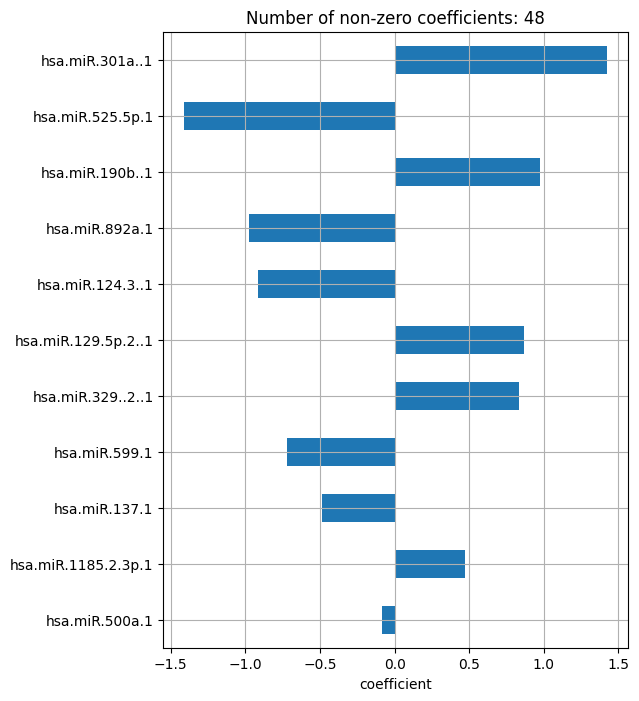

In [8]:
coefficients =  pd.DataFrame({'coefficient': [v[0] for v in coxnet_dict['8000'].coef_]}, 
                            index=train_df.columns[:-3])
# coefficients[coefficients!=0]

non_zero = np.sum(coefficients.iloc[:, 0] != 0)

non_zero_coefs = coefficients[abs(coefficients["coefficient"]) > 5e-2]
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

fig, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)
ax.set_title(f"Number of non-zero coefficients: {non_zero}")
fig.savefig(
    os.path.join("models",DATANAME, 'coxnet','top-coefficients.jpg')
)

## Weak Signals

Train event rate: 0.750625
Test event rate:  0.7645


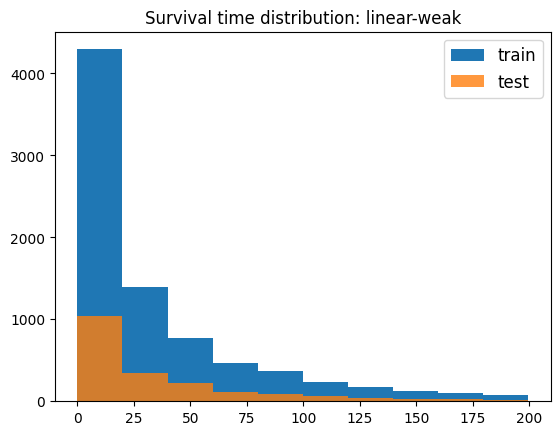

In [18]:
# prepare data
folder = 'linear'
keywords=['weak', 'latest','RW']
DATANAME = 'linear-weak'
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords)

X_train, y_train = dataframe_to_scikitsurv_ds(train_df)
X_test, y_test = dataframe_to_scikitsurv_ds(test_df)

print(f"Train event rate: {train_df.status.value_counts()[1]/train_df.shape[0]}")
print(f"Test event rate:  {test_df.status.value_counts()[1] /test_df.shape[0]}")

plt.hist(train_df['time'], label='train')
plt.hist(test_df['time'], label='test', alpha=0.8)
plt.title('Survival time distribution: %s' % DATANAME)
plt.legend(fontsize=12)
plt.show()
# plt.savefig(f"event_rate_{keyword}.png")

In [20]:
coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[1e-2], max_iter=20000).fit(X_train, y_train)
coxnet.score(X_test, y_test)

/tmp/ipykernel_333672/493714371.py:1: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  coxnet = CoxnetSurvivalAnalysis(l1_ratio=0.9, alphas=[1e-2], max_iter=20000).fit(X_train, y_train)


0.7146173707392219

In [25]:
# parameters for fitting GB models
subset=[
        50,200,500,1000,2000,5000,8000
]
kwargs = {'l1_ratio':0.5, 
        'alphas':[0.1],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet_results

N=50 Training time (0.01s): Train C-Index: 0.963 | Test C-index: 0.678


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=200 Training time (0.29s): Train C-Index: 0.813 | Test C-index: 0.736


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=500 Training time (0.63s): Train C-Index: 0.752 | Test C-index: 0.715


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=1000 Training time (1.08s): Train C-Index: 0.759 | Test C-index: 0.739
N=2000 Training time (0.04s): Train C-Index: 0.758 | Test C-index: 0.751
N=5000 Training time (0.12s): Train C-Index: 0.752 | Test C-index: 0.749
N=8000 Training time (0.25s): Train C-Index: 0.747 | Test C-index: 0.748


,n train,train time,train score,test score
0,50,0.01,0.963037,0.677556
1,200,0.29,0.812677,0.736337
2,500,0.63,0.752242,0.715137
3,1000,1.08,0.758943,0.739402
4,2000,0.04,0.758219,0.750602
5,5000,0.12,0.751580,0.748518
6,8000,0.25,0.746544,0.747991


In [16]:
coxnet_results.to_csv(os.path.join('models', DATANAME, 'coxnet','model.results.1030.txt'))

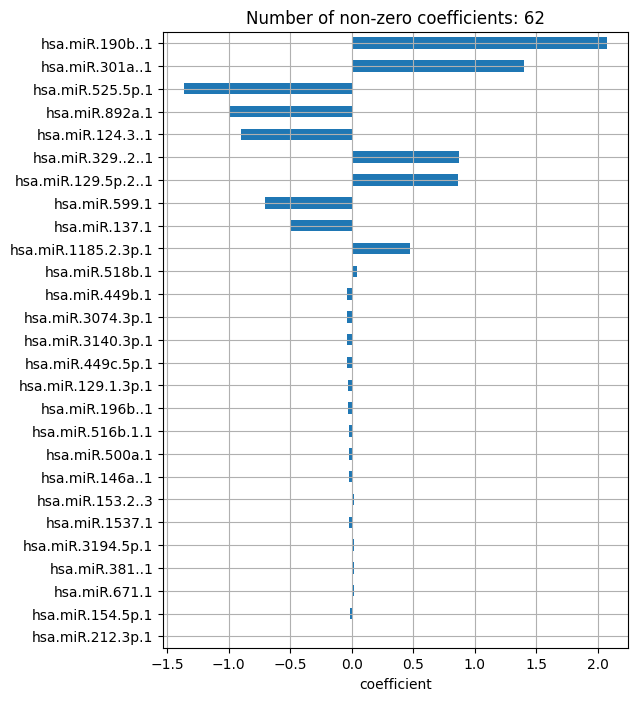

In [17]:
coefficients =  pd.DataFrame({'coefficient': [v[0] for v in coxnet_dict['8000'].coef_]}, 
                            index=train_df.columns[:-3])
# coefficients[coefficients!=0]

non_zero = np.sum(coefficients.iloc[:, 0] != 0)

non_zero_coefs = coefficients[abs(coefficients["coefficient"]) > 1e-2]
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

fig, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)
ax.set_title(f"Number of non-zero coefficients: {non_zero}")
fig.savefig(
    os.path.join("models", DATANAME, 'coxnet','top-coefficients.jpg')
)

## Nonlinear

### Quadratic: Interaction between genes

Event rate in train set: 0.751750
Event rate in test set: 0.732500
Survival time distribution:


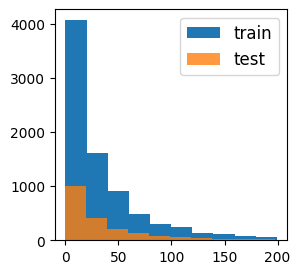

In [26]:
# prepare data
folder = 'nonlinear'
keywords = ['quadratic', "latest", 'RW']
DATANAME = 'nl-quadratic'
train_df, test_df = load_simulate_survival_data(folder=folder, keywords=keywords)

X_train, Y_train, E_train, = dataframe_to_deepsurv_ds(train_df, is_deepsurvk=True)
X_test, Y_test, E_test = dataframe_to_deepsurv_ds(test_df, is_deepsurvk=True)

print("Event rate in train set: %f" % (sum(E_train==1) / len(E_train)))
print("Event rate in test set: %f" %  (sum(E_test==1)  / len(E_test)))
print('Survival time distribution:')
_, ax = plt.subplots(figsize=(3,3))
ax.hist(train_df['time'], label='train')
ax.hist(test_df['time'], label='test', alpha=0.8)
ax.legend(fontsize=12)
plt.show()

In [28]:
# parameters for fitting GB models
subset=[
        50,200,500,1000,2000,5000,8000
]
kwargs = {'l1_ratio':0.5, 
        'alphas':[0.01],
        'max_iter':20000
        }
coxnet = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
coxnet.build_model(**kwargs)
coxnet_results, coxnet_dict = coxnet.train(subset=subset)
coxnet_results

N=50 Training time (0.0s): Train C-Index: 0.644 | Test C-index: 0.509
N=200 Training time (0.0s): Train C-Index: 0.5 | Test C-index: 0.5
N=500 Training time (0.0s): Train C-Index: 0.5 | Test C-index: 0.5


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: UserWarning: all coefficients are zero, consider decreasing alpha.
  model = self.model.fit(x_train, y_train)
/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: UserWarning: all coefficients are zero, consider decreasing alpha.
  model = self.model.fit(x_train, y_train)
/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: UserWarning: all coefficients are zero, consider decreasing alpha.
  model = self.model.fit(x_train, y_train)


N=1000 Training time (0.01s): Train C-Index: 0.5 | Test C-index: 0.5
N=2000 Training time (0.02s): Train C-Index: 0.5 | Test C-index: 0.5


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: UserWarning: all coefficients are zero, consider decreasing alpha.
  model = self.model.fit(x_train, y_train)
/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: UserWarning: all coefficients are zero, consider decreasing alpha.
  model = self.model.fit(x_train, y_train)


N=5000 Training time (0.05s): Train C-Index: 0.5 | Test C-index: 0.5


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: UserWarning: all coefficients are zero, consider decreasing alpha.
  model = self.model.fit(x_train, y_train)


N=8000 Training time (0.08s): Train C-Index: 0.5 | Test C-index: 0.5


,n train,train time,train score,test score
0,50,0.00,0.644356,0.508962
1,200,0.00,0.500000,0.500000
2,500,0.00,0.500000,0.500000
3,1000,0.01,0.500000,0.500000
4,2000,0.02,0.500000,0.500000
5,5000,0.05,0.500000,0.500000
6,8000,0.08,0.500000,0.500000


In [ ]:
coxnet_results.to_csv(os.path.join('models', DATANAME, 'coxnet','model.results.1030.txt'))

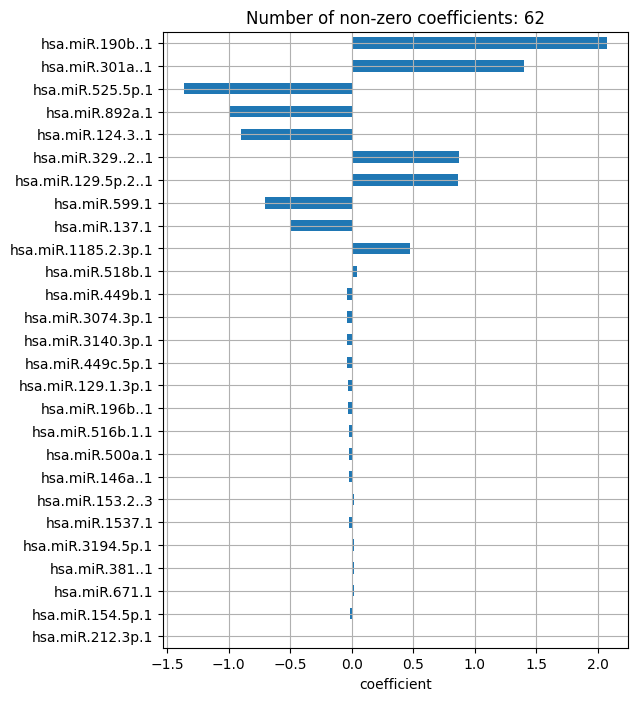

In [ ]:
coefficients =  pd.DataFrame({'coefficient': [v[0] for v in coxnet_dict['8000'].coef_]}, 
                            index=train_df.columns[:-3])
# coefficients[coefficients!=0]

non_zero = np.sum(coefficients.iloc[:, 0] != 0)

non_zero_coefs = coefficients[abs(coefficients["coefficient"]) > 1e-2]
coef_order = non_zero_coefs.abs().sort_values("coefficient").index

fig, ax = plt.subplots(figsize=(6, 8))
non_zero_coefs.loc[coef_order].plot.barh(ax=ax, legend=False)
ax.set_xlabel("coefficient")
ax.grid(True)
ax.set_title(f"Number of non-zero coefficients: {non_zero}")
fig.savefig(
    os.path.join("models", DATANAME, 'coxnet','top-coefficients.jpg')
)

In [ ]:
# dsk_results
dsk.write(dsk_results, fileName='model.results.1030.txt')

# Baseline: CoxPH Models

### Hyperparameter search

In [19]:
alphas = 10.0 ** np.linspace(-4, 4, 10)
coefficients = {}
cph = CoxPHSurvivalAnalysis()
for alpha in alphas:
    cph.set_params(alpha=alpha)
    cph.fit(X_train, y_train)
    key = round(alpha, 5)
    coefficients[key] = cph.coef_

coefficients = pd.DataFrame.from_dict(coefficients).rename_axis(index="feature", columns="alpha").set_index(X_train.columns)
plot_coefficients(coefficients, n_highlight=5)

/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:170: RuntimeWarning: overflow encountered in exp
  risk_set2 += np.exp(xw[k])
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:470: RuntimeWarning: invalid value encountered in scalar divide
  res = np.abs(1 - (loss_new / loss))
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:194: RuntimeWarning: overflow encountered in exp
  exp_xw = np.exp(offset + np.dot(x, w))
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:223: RuntimeWarning: invalid value encountered in multiply
  risk_set_x2 += exp_xw[k] * xk
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:224: RuntimeWarning: invalid value encountered in multiply
  risk_set_xx2 += exp_xw[k] * xx
/home/nfs/dengy/python3.10/lib/python3.10/site-packages/sksurv/linear_model/coxph.py:238: RuntimeWarning: invalid value en

ValueError: LAPACK reported an illegal value in 5-th argument.

In [13]:
# parameters for fitting GB models
subset=[
        50,200,500,1000,2000,5000,8000
]
kwargs = {'l1_ratio':0.001, 
        'alphas': [1e-2],
        'max_iter':20000}
cph = CoxPHElasticNetModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
cph.build_model(**kwargs)
cph_results, cph_dict = cph.train(subset=subset)
cph_results
# coxnet.write(coxnet_dict)

/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=50 Training time (1.57s): Train C-Index: 0.73 | Test C-index: 0.67
N=200 Training time (0.62s): Train C-Index: 0.976 | Test C-index: 0.743


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=500 Training time (8.22s): Train C-Index: 0.919 | Test C-index: 0.777


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=1000 Training time (15.45s): Train C-Index: 0.884 | Test C-index: 0.799


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=2000 Training time (38.2s): Train C-Index: 0.64 | Test C-index: 0.655


/home/nfs/dengy/dl-survival-miRNA/scr/runSurvModels.py:101: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=20000).
  model = self.model.fit(x_train, y_train)


N=5000 Training time (102.71s): Train C-Index: 0.848 | Test C-index: 0.832
N=8000 Training time (53.3s): Train C-Index: 0.846 | Test C-index: 0.836


,n train,train time,train score,test score
0,50,1.57,0.730359,0.670015
1,200,0.62,0.975636,0.743456
2,500,8.22,0.918693,0.777148
3,1000,15.45,0.883972,0.799484
4,2000,38.20,0.640261,0.655225
5,5000,102.71,0.848316,0.831628
6,8000,53.30,0.845935,0.836186


In [15]:
# parameters for fitting GB models
subset=[
        50,200,500,1000,2000,5000,8000
]
kwargs = {'alpha': 0.9}
cph = CoxPHModel(X_train, y_train, X_test, y_test, dataName=DATANAME)
cph.build_model(**kwargs)
cph_results, cph_dict = cph.train(subset=subset)
cph_results
# coxnet.write(coxnet_dict)

N=50 Training time (5.04s): Train C-Index: 1.0 | Test C-index: 0.653
N=200 Training time (21.79s): Train C-Index: 0.988 | Test C-index: 0.735
N=500 Training time (47.02s): Train C-Index: 0.964 | Test C-index: 0.757


KeyboardInterrupt: 